In [2]:
##### Load packages #####
library(tidyverse)
library(multcomp)
library(ggplot2)
library(car)
library(MASS)
library(stats)
library(sjPlot)
library(tidyverse)
library(lme4)
library(lmerTest)
library(LMERConvenienceFunctions)
library(multcomp)

In [3]:
# Load CSV
dir_name <- basename(getwd())
csv_file <- paste0(dir_name, ".csv")
graphdata <- read.csv(csv_file)

Trial_list <- c("Trial01", "Trial02", "Trial03", "Trial04", "Trial05", "Trial06", "Trial07", "Trial08", "Trial09", "Trial10")

#add column index
colnames(graphdata) <- paste0(sprintf("%02d", seq_along(colnames(graphdata))), " ", colnames(graphdata))

# Identify rows with NA (used to detect the gaps) in graphdata
gap_rows <- which(rowSums(is.na(graphdata)) == ncol(graphdata))

# Assign groups dynamically using Trial_list
graphdata$Group <- NA  # Initialize Group column

# Create a sequence of rows to handle gaps
gap_rows <- c(0, gap_rows, nrow(graphdata) + 1)  # Include start and end boundaries
current_trial_index <- 1  # Start from the first trial in Trial_list

# Assign groups dynamically
for (i in seq_along(gap_rows[-1])) {
  start <- gap_rows[i] + 1  # Start of the current block
  end <- gap_rows[i + 1] - 1  # End of the current block
  
  if (start <= end) {
    graphdata$Group[start:end] <- Trial_list[current_trial_index]
    current_trial_index <- current_trial_index + 1
    
    # Loop back to the start of Trial_list if necessary
    if (current_trial_index > length(Trial_list)) {
      current_trial_index <- 1
    }
  }
}

# Print the result to check
print(head(graphdata))

# Reshape graphdata to long format and keep Group in the third column
stacked_graphdata <- graphdata %>%
  pivot_longer(cols = -Group,  # Exclude the Group column from pivoting
               names_to = "ind",  # Column names will go to 'ind'
               values_to = "values") %>%  # Data will go to 'values'
  relocate(Group, .after = ind)  # Move Group column to the third position

# View the result
print(head(stacked_graphdata))

# Create the tallcsv dataframe with renamed columns
tallcsv <- stacked_graphdata %>%
  rename(
    VALUE = values,       
    Treatment = ind,      
    Trial = Group         
  ) %>%
  arrange(Trial, Treatment)  

# View the resulting dataframe
print(head(tallcsv))

#delete NA row
tallcsv2 <- tallcsv[!is.na(tallcsv$VALUE),]

#export
csv_file2 <- paste0(dir_name, "_tall.csv")
write.csv(tallcsv2,csv_file2, row.names = FALSE)

   01 wt_0h 02 wt_2h 03 armsext_13_0h 04 armsext_13_2h 05 armsext_17_0h
1 1.1258022 27.58031        1.0335042         25.31420        0.9250796
2 0.8637135 27.36167        0.8922891         24.71525        1.0175347
3 0.8933392 24.76529        1.0401133         25.05241        1.0740952
4 1.1512028 23.19471        1.0425611         25.48241        0.9890742
5        NA       NA               NA               NA               NA
6 1.0197095 26.93148        0.9504016         26.95862        0.9969337
  06 armsext_17_2h 07 flg22_0h 08 flg22_2h   Group
1         25.47422   0.9583564    66.21216 Trial01
2         24.57482   0.7252888    62.03856 Trial01
3         25.79506   1.1334753    63.97546 Trial01
4         25.56523   1.2692580    61.13788 Trial01
5               NA          NA          NA    <NA>
6         22.28263   0.8330340    91.31333 Trial02
# A tibble: 6 × 3
  ind              Group   values
  <chr>            <chr>    <dbl>
1 01 wt_0h         Trial01  1.13 
2 02 wt_2h         

# A tibble: 6 × 3
  Treatment Trial    VALUE
  <chr>     <chr>    <dbl>
1 01 wt_0h  Trial01  1.13 
2 01 wt_0h  Trial01  0.864
3 01 wt_0h  Trial01  0.893
4 01 wt_0h  Trial01  1.15 
5 02 wt_2h  Trial01 27.6  
6 02 wt_2h  Trial01 27.4  


[1] 61 62

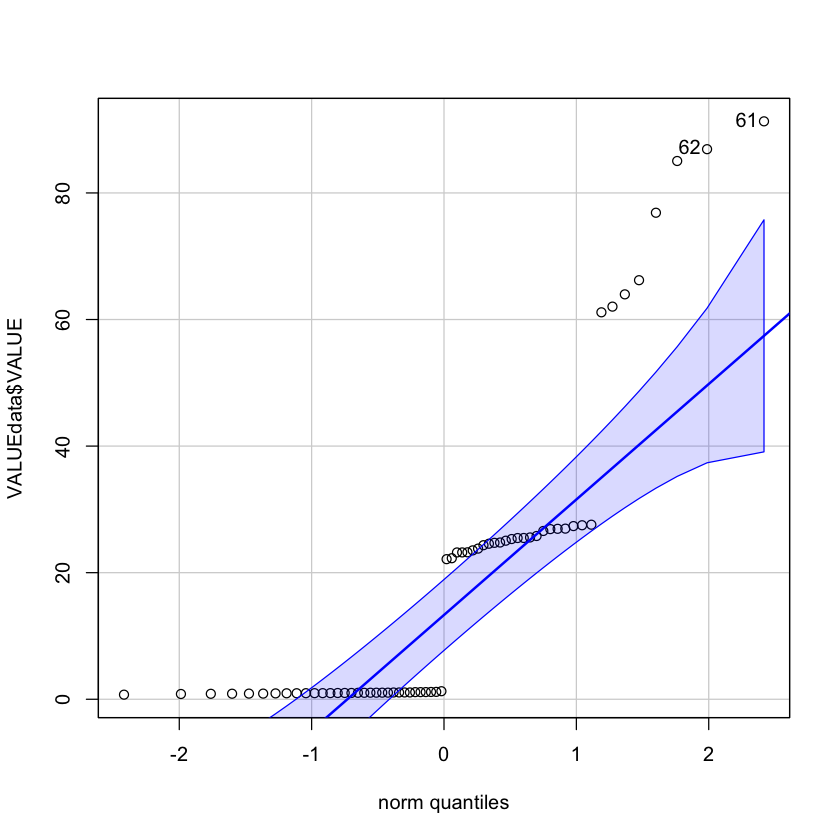

In [4]:
#VALUEdata=read.csv(choose.files())
VALUEdata <- tallcsv2
VALUEdata$VALUE <- as.numeric(as.character(VALUEdata$VALUE))
print(head(VALUEdata))
#Normal distribution
qqp(VALUEdata$VALUE, "norm")

Linear mixed model fit by maximum likelihood . t-tests use Satterthwaite's
  method [lmerModLmerTest]
Formula: VALUE ~ Treatment + (1 | Trial)
   Data: VALUEdata

     AIC      BIC   logLik deviance df.resid 
   383.2    404.8   -181.6    363.2       54 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.0106 -0.2149  0.0798  0.2137  4.0136 

Random effects:
 Groups   Name        Variance Std.Dev.
 Trial    (Intercept)  1.015   1.007   
 Residual             16.503   4.062   
Number of obs: 64, groups:  Trial, 2

Fixed effects:
                           Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)                1.004893   1.603227 19.125249   0.627    0.538    
Treatment02 wt_2h         24.327880   2.031168 62.000000  11.977   <2e-16 ***
Treatment03 armsext_13_0h -0.001437   2.031168 62.000000  -0.001    0.999    
Treatment04 armsext_13_2h 24.662016   2.031168 62.000000  12.142   <2e-16 ***
Treatment05 armsext_17_0h -0.004028   2.031168 62.000000  -0.00

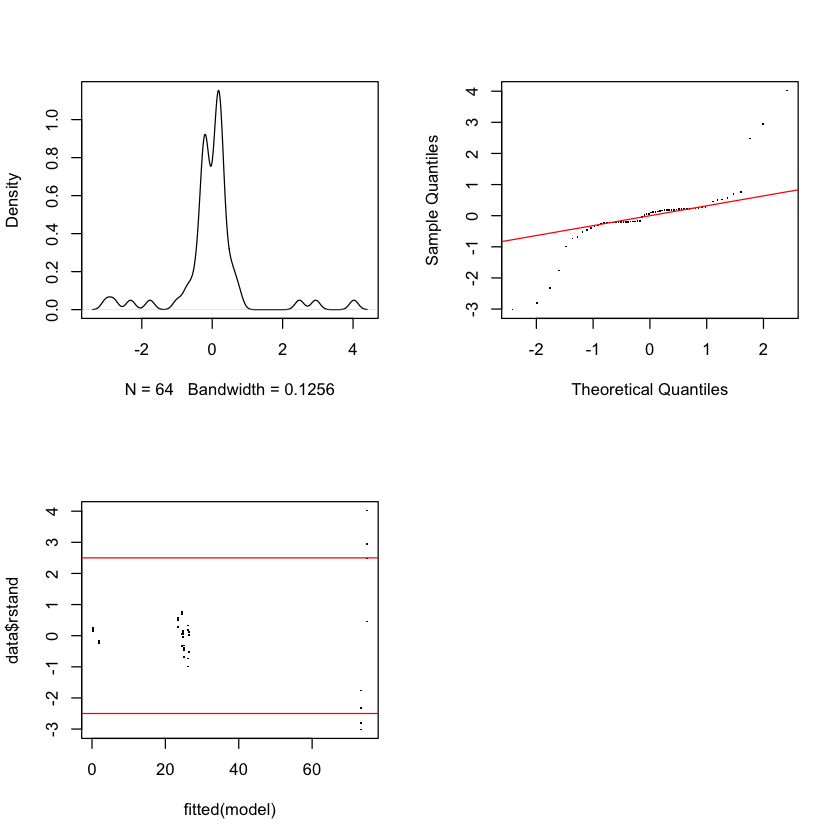

In [5]:
#set REML to FALSE if the data is normal, so we can use the maximum likelihood because the data are normal, we have similar sample sizes between effects, and we only have one random effect
VALUE.lmm<-lmer(VALUE ~ Treatment + (1|Trial), data = VALUEdata, REML = FALSE)
m<-lmer(VALUE ~ Treatment + (1|Trial), data = VALUEdata, REML = FALSE)
#the density plot should look roughly normal, centered on 0. In the quantile plot the black dots should roughly mirror the red line. And in the fitted residual plot most black dots should be between the red lines, with no obvious skew from left to right.
mcp.fnc(VALUE.lmm)
#If the above looks good, then we can get the model characteristics
summary(VALUE.lmm)
summary_name1 <- paste0("01.",dir_name, "_LMM_summary.txt")
capture.output(summary(VALUE.lmm), file = summary_name1)

In [6]:
#anova analysis of lmm
aov <- anova(m)
print(summary(aov))
# Save the summary to a text file
summary_name2 <- paste0("02.",dir_name, "_anova_summary.txt")
capture.output(summary(aov), file = summary_name2)

#Tukey's post-hoc, load library multcomp
tukey_result <- glht(m, linfct = mcp(Treatment = "Tukey"))
multcomps <- cld(tukey_result, alpha=0.1)
print(summary(tukey_result))
# Save the summary to a text file
summary_name3 <- paste0("03.",dir_name, "_multcomp_summary.txt")
capture.output(summary(tukey_result), file = summary_name3)

print(multcomps)
multcomp_name <- paste0("04.",dir_name, "_multcomp_letters.txt")
capture.output(print(multcomps), file = multcomp_name)

     Sum Sq         Mean Sq         NumDF       DenDF       F value     
 Min.   :35624   Min.   :5089   Min.   :7   Min.   :62   Min.   :308.4  
 1st Qu.:35624   1st Qu.:5089   1st Qu.:7   1st Qu.:62   1st Qu.:308.4  
 Median :35624   Median :5089   Median :7   Median :62   Median :308.4  
 Mean   :35624   Mean   :5089   Mean   :7   Mean   :62   Mean   :308.4  
 3rd Qu.:35624   3rd Qu.:5089   3rd Qu.:7   3rd Qu.:62   3rd Qu.:308.4  
 Max.   :35624   Max.   :5089   Max.   :7   Max.   :62   Max.   :308.4  
     Pr(>F)         
 Min.   :1.146e-45  
 1st Qu.:1.146e-45  
 Median :1.146e-45  
 Mean   :1.146e-45  
 3rd Qu.:1.146e-45  
 Max.   :1.146e-45  

	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: lmer(formula = VALUE ~ Treatment + (1 | Trial), data = VALUEdata, 
    REML = FALSE)

Linear Hypotheses:
                                           Estimate Std. Error z value Pr(>|z|)
02 wt_2h - 01 wt_0h == 0                  24.32788